### Stock Market Prediction And Forecasting Using Stacked LSTM

### Import the Libraries

In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data, wb
from pandas.util.testing import assert_frame_equal
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import math
import datetime
import plotly
import cufflinks as cf
cf.go_offline()
%matplotlib inline

/Users/siddhantgolangade/opt/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


### Set Duration

In [2]:
start = datetime.datetime(2015, 7, 11)
end = datetime.datetime(2020, 7, 11)

### Import the data using DataReader

In [3]:
df = data.DataReader("GOOG",'yahoo',start,end)
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-07-10,532.559998,525.549988,526.289978,530.130005,1956700,530.130005
2015-07-13,547.109985,532.400024,532.880005,546.549988,2206500,546.549988
2015-07-14,565.848999,546.710022,546.760010,561.099976,3244100,561.099976
2015-07-15,566.502991,556.789978,560.130005,560.219971,1784600,560.219971
2015-07-16,580.679993,565.000000,565.119995,579.849976,4768300,579.849976


In [4]:
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-07-06,1506.589966,1472.859985,1480.060059,1495.699951,1564000,1495.699951
2020-07-07,1516.800049,1483.550049,1490.000000,1485.180054,1458200,1485.180054
2020-07-08,1505.880005,1485.630005,1494.319946,1496.000000,1249700,1496.000000
2020-07-09,1522.719971,1488.084961,1506.449951,1510.989990,1423300,1510.989990
2020-07-10,1543.829956,1496.540039,1506.150024,1541.739990,1856300,1541.739990


### Exploratory Data Analysis

#### Maximum Closing Rate

In [5]:
df.xs(key='Close',axis=1).max()

1541.739990234375

#### Visualization (Closing Rate)

In [6]:
df.xs(key='Close',axis=1).iplot()

#### 30-day Moving Average for Close Price

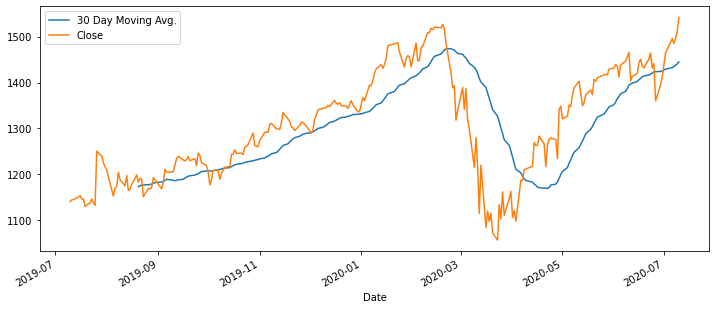

In [7]:
plt.figure(figsize=(12,5))
df['Close'].loc['2019-07-10':'2020-07-10'].rolling(window=30).mean().plot(label='30 Day Moving Avg.')
df['Close'].loc['2019-07-10':'2020-07-10'].plot(label='Close')
plt.legend()

In [8]:
df0 = df[['Open','High','Low','Close']].loc['2019-07-10':'2020-07-10']
df0.iplot(kind='candle')

In [9]:
df['Close'].loc['2019-07-10':'2020-07-10'].ta_plot(study='sma',periods=[9,18,27])

#### Let's Reset the Index to Close

In [10]:
df1=df.reset_index()['Close']

In [11]:
df1

0        530.130005
1        546.549988
2        561.099976
3        560.219971
4        579.849976
           ...     
1255    1495.699951
1256    1485.180054
1257    1496.000000
1258    1510.989990
1259    1541.739990
Name: Close, Length: 1260, dtype: float64

#### Using MinMaxScaler

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [13]:
print(df1)

[[0.        ]
 [0.01623154]
 [0.03061454]
 ...
 [0.95478496]
 [0.96960291]
 [1.        ]]


#### Splitting the Close data into Train and Test sets

In [14]:
training_size=int(len(df1)*0.70)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [15]:
training_size,test_size

(882, 378)

In [16]:
train_data

array([[0.        ],
       [0.01623154],
       [0.03061454],
       [0.02974463],
       [0.04914935],
       [0.14116111],
       [0.13136487],
       [0.1306531 ],
       [0.13045539],
       [0.11283995],
       [0.09235772],
       [0.09601527],
       [0.09674677],
       [0.10063166],
       [0.10128411],
       [0.09438418],
       [0.09991995],
       [0.09798242],
       [0.11234569],
       [0.11125828],
       [0.10396297],
       [0.10241099],
       [0.12915059],
       [0.12794456],
       [0.12487027],
       [0.12553256],
       [0.12923952],
       [0.12455393],
       [0.12926921],
       [0.11536068],
       [0.08140487],
       [0.05879734],
       [0.05133401],
       [0.09735965],
       [0.10624646],
       [0.09909946],
       [0.08710866],
       [0.06688346],
       [0.08324357],
       [0.07524639],
       [0.06976009],
       [0.08355984],
       [0.0816421 ],
       [0.09017306],
       [0.09454238],
       [0.09204139],
       [0.10380484],
       [0.104

In [17]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [18]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [19]:
print(X_train.shape), print(y_train.shape)

(781, 100)
(781,)


(None, None)

In [20]:
print(X_test.shape), print(y_test.shape)

(277, 100)
(277,)


(None, None)

In [21]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

### Stacked LSTM Model

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [23]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 2s 180ms/step - loss: 0.0350 - val_loss: 0.0782
Epoch 2/100
13/13 [==============================] - 1s 102ms/step - loss: 0.0070 - val_loss: 0.0110
Epoch 3/100
13/13 [==============================] - 1s 102ms/step - loss: 0.0027 - val_loss: 0.0070
Epoch 4/100
13/13 [==============================] - 1s 101ms/step - loss: 0.0015 - val_loss: 0.0082
Epoch 5/100
13/13 [==============================] - 1s 101ms/step - loss: 0.0012 - val_loss: 0.0062
Epoch 6/100
13/13 [==============================] - 1s 101ms/step - loss: 0.0011 - val_loss: 0.0061
Epoch 7/100
13/13 [==============================] - 1s 100ms/step - loss: 0.0011 - val_loss: 0.0069
Epoch 8/100
13/13 [==============================] - 1s 101ms/step - loss: 0.0011 - val_loss: 0.0071
Epoch 9/100
13/13 [==============================] - 1s 101ms/step - loss: 0.0011 - val_loss: 0.0074
Epoch 10/100
13/13 [==============================] - 1s 101ms/step - loss: 0.0011 - val_lo

### Lets Predict

In [31]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [32]:
# Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [33]:
### Calculate RMSE performance metrics
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

930.3296729613704

In [34]:
### Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

1262.2362763488986

### Let's Visualize the Predictions

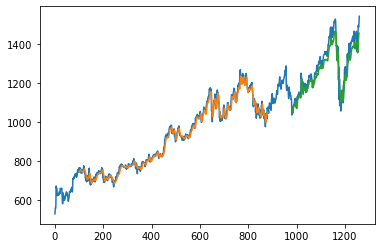

In [35]:
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [36]:
len(test_data)

378

In [37]:
x_input=test_data[278:].reshape(1,-1)
x_input.shape

(1, 100)

In [38]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [39]:
temp_input

[0.9851226766777169,
 0.9766807700972678,
 0.9440199229912384,
 0.8812289062446262,
 0.8484692309465217,
 0.8531450473259129,
 0.7789167488927681,
 0.7999129732696889,
 0.8491216900851671,
 0.8019493891054165,
 0.8465614486306382,
 0.7798559183908403,
 0.7594626787218558,
 0.677563550811266,
 0.7416494702796838,
 0.6774152481884815,
 0.578068660614938,
 0.6816856155747438,
 0.5478395421129371,
 0.5829025538339122,
 0.5601665188668327,
 0.5784443042802984,
 0.5359673681135363,
 0.5204476012080931,
 0.5973942179353499,
 0.5657911582917515,
 0.6243710562996093,
 0.5739167905236916,
 0.6096123509416854,
 0.6254189488758987,
 0.568885240920567,
 0.5839305359685748,
 0.5612340805460624,
 0.6492522301806335,
 0.6488469018568476,
 0.6723441190407896,
 0.6735006140259526,
 0.6795405973301424,
 0.7306175169169368,
 0.7239350900295868,
 0.724923613289025,
 0.7444766323213557,
 0.7280275908039823,
 0.6783345072449268,
 0.7246665875880237,
 0.7376163388221392,
 0.7405819086004538,
 0.73719122072606

In [40]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.92594975]
101
1 day input [0.97668077 0.94401992 0.88122891 0.84846923 0.85314505 0.77891675
 0.79991297 0.84912169 0.80194939 0.84656145 0.77985592 0.75946268
 0.67756355 0.74164947 0.67741525 0.57806866 0.68168562 0.54783954
 0.58290255 0.56016652 0.5784443  0.53596737 0.5204476  0.59739422
 0.56579116 0.62437106 0.57391679 0.60961235 0.62541895 0.56888524
 0.58393054 0.56123408 0.64925223 0.6488469  0.67234412 0.67350061
 0.6795406  0.73061752 0.72393509 0.72492361 0.74447663 0.72802759
 0.67833451 0.72466659 0.73761634 0.74058191 0.73719122 0.69546569
 0.80203832 0.80913597 0.78140785 0.78752687 0.81155781 0.8077916
 0.8327617  0.84839019 0.86310932 0.83590514 0.80979821 0.81652021
 0.83338436 0.84401098 0.83367601 0.86652957 0.86265464 0.87018718
 0.87671141 0.87752194 0.8764247  0.88847486 0.89134148 0.89865658
 0.8958492  0.87192699 0.89783615 0.90596178 0.91540222 0.92498096
 0.86368262 0.87291551 0.87950889 0.90211641 0.91042003 0.89543398
 0.89124265 0.91115152 0.92355754 

### Predictions for Next 30 Days

In [41]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [42]:
len(df1)

1260

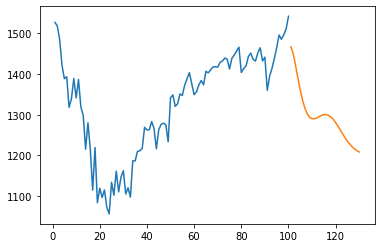

In [43]:
plt.plot(day_new,scaler.inverse_transform(df1[1160:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

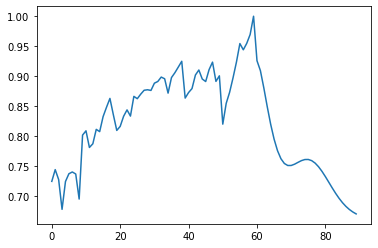

In [44]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [45]:
df3=scaler.inverse_transform(df3).tolist()

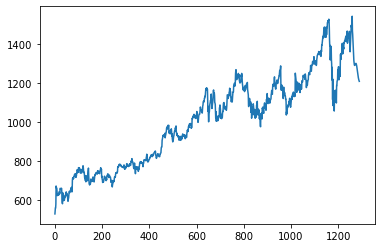

In [46]:
plt.plot(df3)

**CONCLUSION:** Here, we can see that the predictions seem to be close to Perfect. The Error rates are pretty low which acts as a good sign for our model.